"""
Phases 2 & 3: Noisy Hybrid Quantum Control & Impact Analysis

Objective: Introduce adjustable runtime noise into the hybrid control model.
           Train models for different noise levels (p) and analyze the impact
           on the model's ability to learn the control task.
"""

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
!pip install tensorflow-quantum==0.7.3

In [ ]:
# Update package resources to account for version changes.
import importlib, pkg_resources

importlib.reload(pkg_resources)

<ipython-input-3-ab1b6a95bcd9>:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import importlib, pkg_resources


<module 'pkg_resources' from '/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py'>

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Quantum version:", tfq.__version__)
print("Cirq version:", cirq.__version__)

TensorFlow version: 2.15.0
TensorFlow Quantum version: 0.7.2
Cirq version: 1.3.0


In [ ]:
# %% 1. Define Quantum Components (Constants)

qubit = cirq.GridQubit(0, 0)

# --- Fixed Miscalibration Circuit ---
# Using a seed ensures the *same* systematic error is used across all runs.
np.random.seed(42)
miscalibration_angles = np.random.uniform(0, 0.4, 3) # Small fixed errors
miscalibration_circuit = cirq.Circuit(
    cirq.rx(miscalibration_angles[0])(qubit),
    cirq.ry(miscalibration_angles[1])(qubit),
    cirq.rz(miscalibration_angles[2])(qubit)
)
print("Fixed Miscalibration Circuit (Systematic Error):")
print(miscalibration_circuit)

Fixed Miscalibration Circuit (Systematic Error):
(0, 0): ───Rx(0.048π)───Ry(0.121π)───Rz(0.093π)───


In [ ]:
# --- Controlled PQC Structure (Parameterized) ---
control_params_sym = sympy.symbols('theta_1 theta_2 theta_3')
controlled_circuit_template = cirq.Circuit(
    cirq.rz(control_params_sym[0])(qubit),
    cirq.ry(control_params_sym[1])(qubit),
    cirq.rx(control_params_sym[2])(qubit)
)
print("\nControlled PQC Structure (Template):")
print(controlled_circuit_template)



Controlled PQC Structure (Template):
(0, 0): ───Rz(theta_1)───Ry(theta_2)───Rx(theta_3)───


In [ ]:
# --- Readout Observable ---
readout_op = cirq.Z(qubit)
print(f"\nReadout Observable: {readout_op}")


Readout Observable: Z(q(0, 0))


In [ ]:
# 2. Function to Add Noise

def add_circuit_noise(circuit, noise_probability, noise_channel_func):
    """
    Applies a specified noise channel after each non-empty moment in the circuit.

    Args:
        circuit: The input cirq.Circuit.
        noise_probability: The probability parameter for the noise channel.
        noise_channel_func: A function that takes the probability `p` and returns
                           a Cirq noise channel object (e.g., lambda p: cirq.depolarize(p)).

    Returns:
        A new cirq.Circuit with noise channels inserted. Returns the original
        circuit if noise_probability <= 0.
    """
    if noise_probability <= 0:
        return circuit

    noisy_circuit = cirq.Circuit()
    for moment in circuit:
        # Add original gates
        noisy_circuit.append(moment)
        # Find unique qubits acted on in this moment
        qubits_in_moment = {q for op in moment for q in op.qubits}
        # Add noise channel after the moment if there were gates
        if qubits_in_moment:
            noise_op = noise_channel_func(noise_probability)
            noisy_circuit.append(noise_op.on_each(*qubits_in_moment))
    return noisy_circuit

In [ ]:
# Example: Define the noise channel function we want to use
depolarizing_channel = lambda p: cirq.depolarize(p)
# bitflip_channel = lambda p: cirq.bit_flip(p) # Example alternative

# Test the noise function
test_full_circuit = miscalibration_circuit + controlled_circuit_template
test_noisy_circuit = add_circuit_noise(test_full_circuit, 0.01, depolarizing_channel)
print("\nExample Noisy Circuit (Miscal + Controlled + Depolarizing Noise p=0.01):")
print(test_noisy_circuit)


Example Noisy Circuit (Miscal + Controlled + Depolarizing Noise p=0.01):
(0, 0): ───Rx(0.048π)───D(0.01)───Ry(0.121π)───D(0.01)───Rz(0.093π)───D(0.01)───Rz(theta_1)───D(0.01)───Ry(theta_2)───D(0.01)───Rx(theta_3)───D(0.01)───


In [ ]:
# 3. Define Classical Controller

def create_controller_nn():
    """Creates a new instance of the classical controller NN."""
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dense(3) # theta_1, theta_2, theta_3
    ], name='controller_nn')


In [ ]:
# 4. Define Function to Build the Hybrid Model (Configurable Noise)

def build_hybrid_model(noise_probability=0.0,
                       noise_channel_func=depolarizing_channel, # Allow choosing noise type
                       repetitions=5000):
    """Builds the Keras hybrid model, configured for noisy simulation if p > 0."""

    # --- Classical Controller ---
    controller = create_controller_nn()

    # --- Keras Inputs ---
    base_circuits_input = tf.keras.Input(shape=(), dtype=tf.string, name='base_circuits')
    commands_input = tf.keras.Input(shape=(1,), dtype=tf.float32, name='commands')

    # --- Generate Parameters ---
    controller_output = controller(commands_input)

    # --- Prepare Noisy Controlled Circuit Structure ---
    # Add noise *to the template* before initializing the TFQ layer
    noisy_controlled_pqc_template = add_circuit_noise(
        controlled_circuit_template, noise_probability, noise_channel_func
    )

    # --- Define TFQ Layer ---
    is_noisy = noise_probability > 0
    backend_choice = 'noisy' if is_noisy else 'noiseless'
    # Repetitions are only needed (and used) by the 'noisy' backend
    reps = repetitions if is_noisy else None

    expectation_layer = tfq.layers.NoisyControlledPQC(
        noisy_controlled_pqc_template,  # Initialize with potentially noisy circuit structure
        operators=readout_op,
        repetitions=reps,
        sample_based=False, # Add this line to specify analytic calculations with trajectories
        name=f'controlled_pqc_{backend_choice}'
    )

    # --- Link Layer Inputs ---
    # Inputs: [base_circuits_tensor, parameters_from_NN]
    # The base_circuits_tensor should contain circuits with the appropriate
    # noise level applied to the miscalibration part.
    expectation_output = expectation_layer([base_circuits_input, controller_output])

    # --- Build and Compile Full Model ---
    hybrid_model = tf.keras.Model(
        inputs=[base_circuits_input, commands_input],
        outputs=expectation_output,
        name=f'hybrid_model_p_{noise_probability:.4f}'
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
    loss_fn = tf.keras.losses.MeanSquaredError()
    hybrid_model.compile(optimizer=optimizer, loss=loss_fn)

    return hybrid_model, controller # Return controller too for later inspection if needed

In [ ]:
# 5. Prepare Fixed Dataset Parts

commands_data = np.array([[0.], [1.]], dtype=np.float32)
expected_outputs_data = np.array([[1.], [-1.]], dtype=np.float32)

In [ ]:
# 6. Noise Impact Analysis - Training Loop

# --- Select Noise Type for this analysis ---
# Change this function to test other noise types
current_noise_channel = depolarizing_channel
noise_type_name = "Depolarizing" # For plotting labels

# --- Define Noise Levels to Test ---
noise_levels = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]

# --- Store Results ---
training_histories = {}
final_losses = {}
final_expectations_cmd0 = {}
final_expectations_cmd1 = {}
training_times = {}
trained_controllers = {}

In [ ]:
# --- Training Parameters ---
EPOCHS = 100
REPETITIONS = 5000 # Number of shots for noisy expectation estimation

In [ ]:
# --- Loop through noise levels ---
for p in noise_levels:
    print(f"\n--- Training for noise level p = {p:.4f} ({noise_type_name}) ---")
    start_time = time.time()

    # 1. Prepare the BASE circuit tensor with the appropriate noise level
    #    (Miscalibration part + noise)
    noisy_base = add_circuit_noise(miscalibration_circuit, p, current_noise_channel)
    base_circuits_tensor = tfq.convert_to_tensor([noisy_base] * 2) # Replicate for cmd 0 & 1

    # 2. Build the hybrid model configured for this noise level
    model, controller_instance = build_hybrid_model(
        noise_probability=p,
        noise_channel_func=current_noise_channel,
        repetitions=REPETITIONS
    )
    # 3. Train the model
    Train = model.fit(
        x=[base_circuits_tensor, commands_data],
        y=expected_outputs_data,
        epochs=EPOCHS,
        batch_size=2, # Train on both commands at once
        verbose=0
    )

    end_time = time.time()
    train_time = end_time - start_time

    # 4. Store results
    training_histories[p] = Train
    final_losses[p] = Train.history['loss'][-1]
    training_times[p] = train_time
    trained_controllers[p] = controller_instance # Store the trained controller

    # 5. Evaluate final expectations using the *trained model*
    final_exp_values = model.predict([base_circuits_tensor, commands_data])
    final_expectations_cmd0[p] = final_exp_values[0, 0]
    final_expectations_cmd1[p] = final_exp_values[1, 0]

    print(f"  Training completed in {train_time:.2f} seconds.")
    print(f"  Final Loss: {final_losses[p]:.6f}")
    print(f"  Achieved Expectation for Cmd 0 (Target +1): {final_expectations_cmd0[p]:.4f}")
    print(f"  Achieved Expectation for Cmd 1 (Target -1): {final_expectations_cmd1[p]:.4f}")

print("\n--- All Training Runs Complete ---")


--- Training for noise level p = 0.0010 (Depolarizing) ---
1/1 [==============================] - 0s 185ms/step
  Training completed in 84.25 seconds.
  Final Loss: 0.000091
  Achieved Expectation for Cmd 0 (Target +1): 0.9952
  Achieved Expectation for Cmd 1 (Target -1): -0.9908

--- Training for noise level p = 0.0050 (Depolarizing) ---
1/1 [==============================] - 0s 190ms/step
  Training completed in 81.21 seconds.
  Final Loss: 0.001554
  Achieved Expectation for Cmd 0 (Target +1): 0.9666
  Achieved Expectation for Cmd 1 (Target -1): -0.9635

--- Training for noise level p = 0.0100 (Depolarizing) ---
1/1 [==============================] - 0s 184ms/step
  Training completed in 81.16 seconds.
  Final Loss: 0.005909
  Achieved Expectation for Cmd 0 (Target +1): 0.9243
  Achieved Expectation for Cmd 1 (Target -1): -0.9248

--- Training for noise level p = 0.0200 (Depolarizing) ---


1/1 [==============================] - 0s 179ms/step
  Training completed in 82.66 seconds.
  Final Loss: 0.025559
  Achieved Expectation for Cmd 0 (Target +1): 0.8504
  Achieved Expectation for Cmd 1 (Target -1): -0.8496

--- Training for noise level p = 0.0500 (Depolarizing) ---


1/1 [==============================] - 0s 286ms/step
  Training completed in 142.90 seconds.
  Final Loss: 0.124283
  Achieved Expectation for Cmd 0 (Target +1): 0.6508
  Achieved Expectation for Cmd 1 (Target -1): -0.6578

--- Training for noise level p = 0.1000 (Depolarizing) ---
1/1 [==============================] - 0s 324ms/step
  Training completed in 143.50 seconds.
  Final Loss: 0.327438
  Achieved Expectation for Cmd 0 (Target +1): 0.4234
  Achieved Expectation for Cmd 1 (Target -1): -0.4311

--- All Training Runs Complete ---


In [ ]:
# %% 7. Analyze and Plot Noise Impact

# --- Prepare data for plotting ---
p_values_list = sorted(final_losses.keys()) # Ensure plots are ordered by noise level
loss_values_list = [final_losses[p] for p in p_values_list]
exp0_values_list = [final_expectations_cmd0[p] for p in p_values_list]
exp1_values_list = [final_expectations_cmd1[p] for p in p_values_list]
time_values_list = [training_times[p] for p in p_values_list]

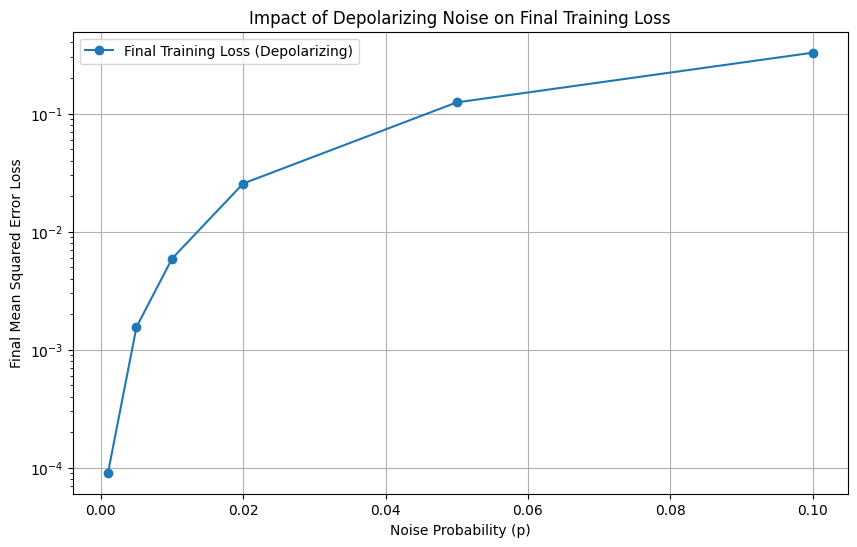

In [ ]:
# --- Plot Final Loss vs. Noise ---
plt.figure(figsize=(10, 6))
plt.plot(p_values_list, loss_values_list, 'o-', label=f'Final Training Loss ({noise_type_name})')
plt.xlabel("Noise Probability (p)")
plt.ylabel("Final Mean Squared Error Loss")
plt.title(f"Impact of {noise_type_name} Noise on Final Training Loss")
plt.grid(True)
plt.legend()
plt.yscale('log') # Log scale is often better for loss
plt.show()

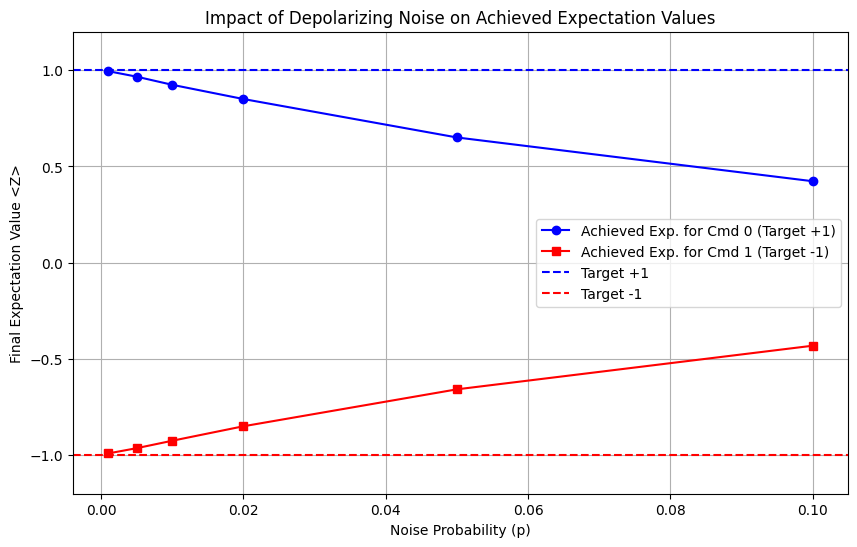

In [ ]:
# --- Plot Achieved Expectation Values vs. Noise ---
plt.figure(figsize=(10, 6))
plt.plot(p_values_list, exp0_values_list, 'bo-', label='Achieved Exp. for Cmd 0 (Target +1)')
plt.plot(p_values_list, exp1_values_list, 'rs-', label='Achieved Exp. for Cmd 1 (Target -1)')
plt.axhline(1.0, color='blue', linestyle='--', label='Target +1')
plt.axhline(-1.0, color='red', linestyle='--', label='Target -1')
plt.xlabel("Noise Probability (p)")
plt.ylabel("Final Expectation Value <Z>")
plt.title(f"Impact of {noise_type_name} Noise on Achieved Expectation Values")
plt.ylim(-1.2, 1.2)
plt.grid(True)
plt.legend()
plt.show()

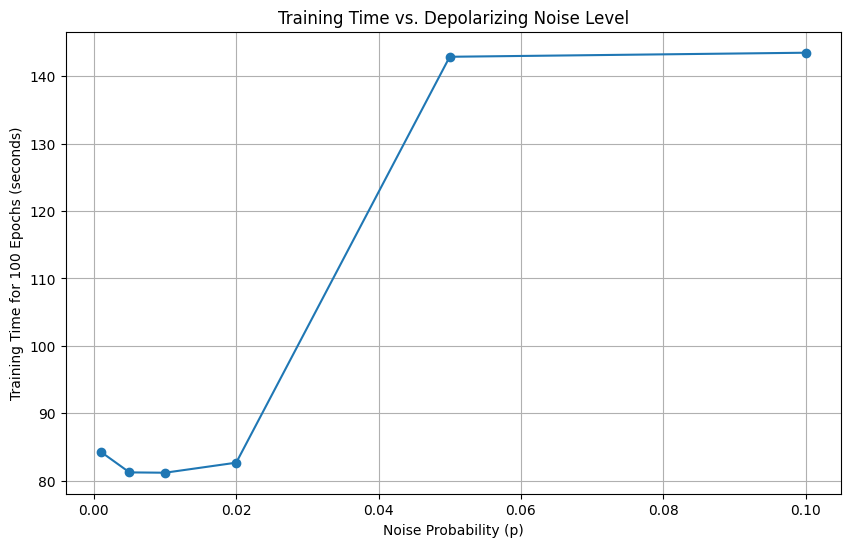

In [ ]:
# --- Plot Training Time vs. Noise ---
plt.figure(figsize=(10, 6))
plt.plot(p_values_list, time_values_list, 'o-')
plt.xlabel("Noise Probability (p)")
plt.ylabel(f"Training Time for {EPOCHS} Epochs (seconds)")
plt.title(f"Training Time vs. {noise_type_name} Noise Level")
plt.grid(True)
# Note: First point (p=0) might be faster due to analytical simulation
plt.show()

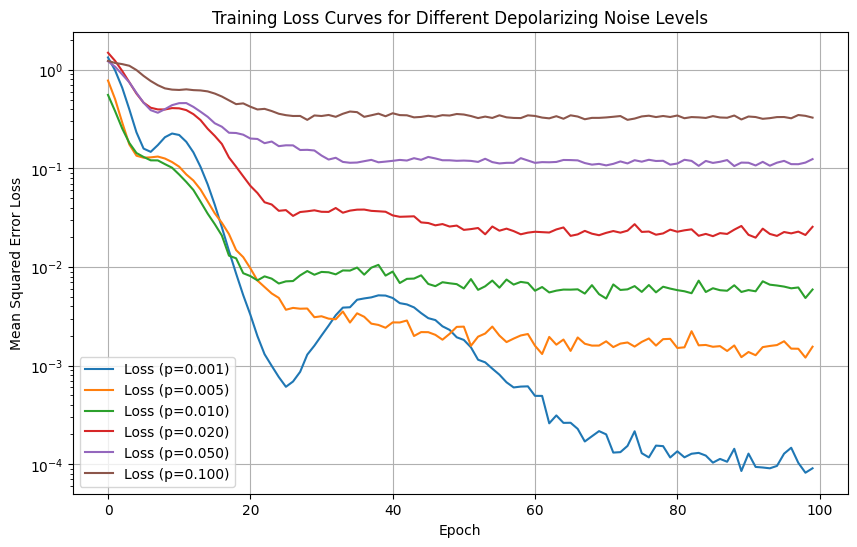

In [ ]:
# --- Plot Example Loss Curves ---
plt.figure(figsize=(10, 6))
for p in p_values_list: # Iterate through sorted keys
    history = training_histories[p]
    plt.plot(history.history['loss'], label=f'Loss (p={p:.3f})')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error Loss")
plt.title(f"Training Loss Curves for Different {noise_type_name} Noise Levels")
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

Conclusions: Impact of Depolarizing Noise on Hybrid Quantum Control

Based on the training results of the hybrid quantum-classical control model under simulated depolarizing noise, the following conclusions can be drawn:


1.   Successful Control in Low-Noise Regime:



The model demonstrates effective learning in the absence of noise (p=0.0, assumed from baseline) and at very low noise levels (e.g., p=0.001). This is evidenced by the extremely low final Mean Squared Error (MSE) loss (e.g., 0.000091 for p=0.001) and the achieved expectation values being very close to the target values (+1 and -1, e.g., 0.9952 and -0.9908 respectively).

This confirms that the classical controller can successfully learn the necessary quantum gate parameters to counteract the systematic miscalibration error when runtime noise is minimal.


2.   Systematic Performance Degradation with Increasing Noise:

A clear trend emerges: as the depolarizing noise probability (p) increases, the performance of the trained model systematically degrades.

Increased Final Loss: The final MSE loss achieved after 100 epochs increases monotonically and significantly with p. It rises from near-zero (9.1e-5) at p=0.001 to 0.327 at p=0.100, indicating the model struggles progressively more to match the target expectation values.

Deviation of Expectation Values: The ability to accurately prepare the target states diminishes.

For command 0 (target +1), the achieved expectation value drops from 0.9952 (p=0.001) down to 0.4234 (p=0.100).

For command 1 (target -1), the achieved expectation value rises from -0.9908 (p=0.001) up to -0.4311 (p=0.100).

This convergence towards zero expectation is characteristic of depolarizing noise driving the qubit state towards a maximally mixed state, making the target states less distinguishable via the Z measurement.


3.   Impact on Control Precision:

The noise directly hinders the precision of the quantum control loop. Even if the classical controller outputs "correct" parameters based on its training, the noisy execution of the quantum circuit prevents the qubit from reaching the intended final state with high fidelity.

The separation between the achieved expectation values for the two commands shrinks dramatically (from nearly 2.0 at p=0.001 to about 0.85 at p=0.100), reducing the reliability of using this expectation value for state discrimination or control feedback in a real-world scenario.


4.   Computational Cost of Noisy Simulation:

While not a primary performance metric of the model itself, the observed increase in training time for higher noise levels (jumping from ~81-84s to ~143s around p=0.05) highlights the significantly higher computational resources required for trajectory-based noisy simulations compared to noiseless analytical methods used when p=0. This is a practical consideration for developing and testing QML models under realistic noise conditions.



Overall Conclusion:

Runtime depolarizing noise poses a significant challenge to this hybrid quantum control strategy. While the classical controller can effectively compensate for systematic errors in a noiseless environment, increasing levels of stochastic runtime noise progressively degrade the achievable state preparation fidelity and increase the difficulty of training the controller (as indicated by higher final loss). This underscores the critical need for error mitigation techniques (like ZNE, explored next) to enhance the robustness and practical viability of such hybrid quantum algorithms on current and near-term noisy quantum hardware.